# Panorama Creation 

This project stitches together multiple images into a single panorama.

The steps I followed are roughly 
1.  Detect keypoints (DoG, Harris, etc.) and extract local invariant descriptors (I use SIFT)
2.  Match the descriptors between the two images.
3.  Estimate a homography matrix using our matched feature vectors.
4.  Apply a warping transformation using the homography matrix obtained from Step #3.
5.  Blend images

In [1]:
#import math
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import imutils
mpl.rc('image', cmap='gray')
#import argparse
#from skimage import exposure
from skimage.exposure import match_histograms

def imshow(img,cmap=None):
    plt.imshow(img,cmap=cmap,interpolation='none')
    plt.axis('off')
    plt.show()





Here I use FLANN (Fast Library for Approximate Nearest Neighbors) which contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. I considered using a brute force matcher (BFMatcher) but chose FLANN since it works faster for large datasets. I hadn't used either before, but they popped up when I was researching different methods, and thought they worked well here. 

In [2]:
#initializing 
sift = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params, search_params)  



In [3]:
#Takes in two images and returns transformation matrix that transforms the corners of the first onto the second
#Uses sift and flann to find points the two images have in common
def match2(i1, i2):
    #convert images to greyscale 
    i1_gray = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
    i2_gray = cv.cvtColor(i2, cv.COLOR_BGR2GRAY)

    # Use sift to compute the raw matches and descriptions 
    pointsPrev, des1 = sift.detectAndCompute(i1_gray, None)
    pointsCurrent, des2 = sift.detectAndCompute(i2_gray, None)

    rawMatches = flann.knnMatch(des2, des1, k=2) 
    goodMatches = []

    #apply Lowe’s ratio test: 
    # https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work
    for i , (m, n) in enumerate(rawMatches):
        if m.distance < 0.7*n.distance:
            goodMatches.append((m.trainIdx, m.queryIdx))

    if len(goodMatches) > 4: #computing a homography requires at least 4 matches
        # construct the two sets of points
        matchedCurrent = np.float32([pointsCurrent[i].pt for (_, i) in goodMatches])
        matchedPrev = np.float32([pointsPrev[i].pt for (i, _) in goodMatches])

        # compute the homography between the two sets of points
        H, s = cv.findHomography(matchedCurrent, matchedPrev, cv.RANSAC, 4)
        return H, len(goodMatches) #3x3 transformation matrix to transform the corners of matchedPointsCurrent to matchedPointsPrev
    else:
        print("Not enough matches between images!")
        return None, 0

##### Relevant Math Definitions:
__Inverse__: A*A<sup>-1</sup> = Identity Matrix <br>
__dot product__: multiply rows of second matrix by columns of the first matrix
 



In the code below, I decided to use planar warping, where every image is an element of a plane surface. I use homographies to translate and rotate the images appropriatly to construct a panorama. I chose this since I didn't want to have to rely on knowing or estimating the focal length of the camera, and am interested in relatively small fields of view

Other common types of warping for larger panoramas are:

- __Cylindrical__: where images are represented imagining a cylindrical coordinate system, and images are plotted on the curved surface of that cylinder. Note cylindrical is usually used when y is constant
- __Spherical__: same as cylindrical, except instead of a cylinder the reference model is a sphere. 

I originally wrote code for combining just two images together in order from left to right. I then expanded that code to allow for multiple images. Lastly I adjusted the function to stitch  images based off the number of matching features they shared (This part is in the for loop below). Originally my matching function only returned the homographs, but I later modified it to return the number of matches between images  to accommodate for this.  

In [ ]:
# Uses bitwise methods to cute away black at the edges of the image
#Note that if the exposure is to aggresive it do not work properly (it starts eating away at black in the image itself)
def trimEdges(results, final_img):
    for res in results[1:]:
        rows,cols,channels = res.shape
        
        res_gray = cv.cvtColor(res, cv.COLOR_BGR2GRAY)
        ret, mask = cv.threshold(res_gray, 0, 255, cv.THRESH_BINARY)
        mask_inv = cv.bitwise_not(mask)


        final_img_bg = cv.bitwise_and(final_img, final_img, mask=mask_inv)
        res_img_fg = cv.bitwise_and(res, res, mask=mask)

        dst = cv.add(final_img_bg, res_img_fg)
        final_img[0:rows,0:cols] = dst

        width, height, channels = final_img.shape
        center = (int(height/2), int(width/2))

        #final_img = blend(final_img, res, mask)
        #final_img = cv.seamlessClone(final_img, res, mask, center, cv.MIXED_CLONE)
            
            #target is main image

    final_img[np.where((final_img==[0,0,0]).all(axis=2))] = [255,255,255] 

    return final_img #cv.cvtColor(final_img, cv.COLOR_BGR2RGB) 

In [102]:
#stitches multiple images together into panorama
#takes in list of images to stitch together (which can be in any order) and a boolean adjust (whether to adjust image histograms)
def shift2(img_list, adjust):
    
    mainImg = img_list.pop(0)  #arbitrarily choose first image as the starting image
    results = [] #array to hold panorama a each step
    #last_img = img_list[-1]

    while img_list: #loop through all images, removing them as they are stitched to the panorama
        best_rating, index, best_index = 0, 0, 0
        worst_rating = 1000

        for image in img_list:
            
            new_H, rating = match2(mainImg, image) # Create transformation matrix from a to b

            #look for the images that has the most points in common with the mainImg
            if rating > best_rating:
                best_rating = rating
                i = image
                H = new_H
                best_index = index
            index +=1

            #look for the last image to go on top
            if rating < worst_rating:
                worst_rating = rating
                last_img = image
        
        img_list.pop(best_index)

        #testing
        #Match all images with exposure of last image, since that image will be on top
        #consider matching main img instead, but then black space affects it a lot
        if adjust:
            i = match_histograms(i, last_img, channel_axis=2)
        

        #Adjust image so that its cumulative histogram matches that of mainImg. This normalizes the representation of images

        #Maybe just adjust the part that overlaps?? It looks worse now lol
        #if adjust:
            #i = match_histograms(i, mainImg, channel_axis=2)

        

        #need to normalize homography matrix so last row amounts to a unit vector
        invH = np.linalg.inv(H) #create inverse 

        h1,w1 = i.shape[0], i.shape[1] #[:2]
        h2,w2 = mainImg.shape[0], mainImg.shape[1] #[:2]

        pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
        pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)


        pts2_ = cv.perspectiveTransform(pts2, invH)
        pts = np.concatenate((pts1, pts2_), axis=0)

        [x_min, y_min] = np.int32(pts.min(axis=0).ravel())   #the starting points for x and y -- this is used as the offset
        [x_max, y_max] = np.int32(pts.max(axis=0).ravel())
        
        Ht = np.array([[1,0, -x_min ],[0,1, -y_min],[0,0,1]]) #translate

        result = cv.warpPerspective(mainImg, Ht.dot(invH), (x_max-x_min, y_max-y_min)) #the final warping of the mainImg so it fits with i's angles


        if results:
            result = trimEdges(results, result)

        result[-y_min:h1-y_min,-x_min:w1-x_min] = i 
        
        results.append(result)
        mainImg = result 
        #mainImg = trimEdges(results, result)
        
    
    return result, results

Note that the panorama looks different depending on which order the images are in, but that is to be expected. 

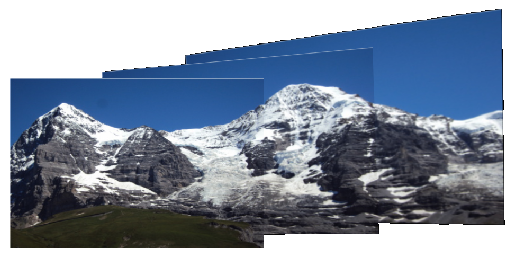

adjusted image


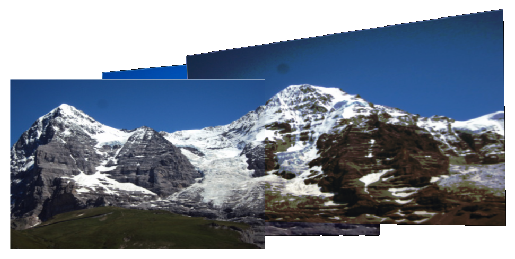

unadjusted image


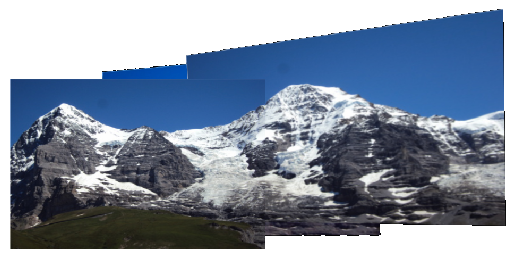

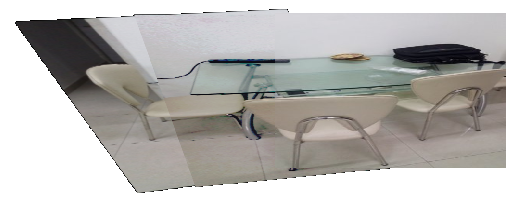

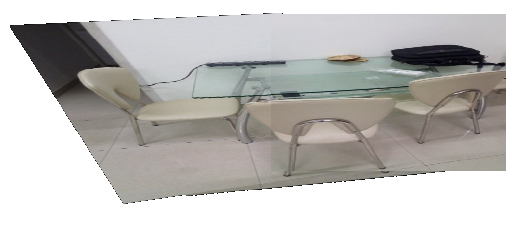

'test1 = cv.imread(\'wd1.jpg\')\ntest2 = cv.imread(\'wd2.jpg\')\n\nprint("testing")\nnew_H  = match(test1, test2)\nimshow(blending(new_H, test1, test2)) '

In [104]:
#testing out some example images. More examples are also included in the summary document 
#filenames = ['1Hill.JPG', '2Hill.JPG', '3Hill.JPG']
filenames = ['wd1.jpg', 'wd2.jpg', 'wd3.jpg']
filenames2 = ['wd2.jpg', 'wd1.jpg', 'wd3.jpg']
hill_photos = ['3Hill.JPG', '1Hill.JPG', '2Hill.JPG']
hannahs = ['hannah1', 'hannah2', 'hannah3', 'hannah4']

hill_photos2 = ['2Hill_exp.jpeg', '1Hill.JPG', '3Hill.JPG']


#given a list of file names returns a array of the images associated with them and resizes the images
def getList(filenames):
#filenames = ['hannah4.jpg', 'hannah3.jpg', 'hannah2.jpg']
    images = [cv.cvtColor(cv.resize(cv.imread(each),(480, 320)), cv.COLOR_BGR2RGB) for each in filenames]
    #images = [(cv.imread(each)) for each in filenames]
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    count = len(images)
    centerIdx = count/2 
    center_im = images[int(centerIdx)]
    left_list = []
    right_list = []
    whole_list = []

    for i in range(count):
        whole_list.append(images[i])
        #whole_list.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))

    for i in range(count):
        if(i<=centerIdx):
            left_list.append(images[i])
        else:
            right_list.append(images[i])
    return left_list, whole_list, right_list


#lh, wh, rh = getList(hannahs)
#final_hannah, resultsh = shift2(wh, False)
#imshow(final_hannah)


l3, w3, r3 = getList(hill_photos)
final_img2, results2 = shift2(w3, False)
imshow(final_img2)


print("adjusted image")
ll3, ww3, rr3 = getList(hill_photos2)
final_img22, results2 = shift2(ww3, True)
imshow(final_img22)

print("unadjusted image")
ll33, ww33, rr33 = getList(hill_photos2)
final_img_true, results2 = shift2(ww33, False)
imshow(final_img_true)



l, w, r = getList(filenames) #in order
final_img, results = shift2(w, True)
imshow(final_img)


l2, w2, r2 = getList(filenames2) #out of order
img_adjust, res2 = shift2(w2, False)
imshow(img_adjust)




'''test1 = cv.imread('wd1.jpg')
test2 = cv.imread('wd2.jpg')

print("testing")
new_H  = match(test1, test2)
imshow(blending(new_H, test1, test2)) '''




#unnecessary since added adge trimming to main shift method
#print("Example of image with edges trimmed")
#imshow(trimEdges(results, final_img))

#imshow(cv.cvtColor(final_img, cv.COLOR_BGR2RGB))


#final_img[np.where((final_img==[0,0,0]).all(axis=2))] = [255,255,255] 



#### For the future
One possible addition in the future is adding linear blending between the images. Below is code that I started for this, but that is  restricted to two images of the same size. Currently the only blending I am using it adjusting the image histograms to help unify the images. I think this is one area with lots of room for improvement in the fture. 

In [7]:
def blend_linear(img1, img2):

    img1mask = ((img1[:,:,0] | img1[:,:,1] | img1[:,:,2]) >0)
    img2mask = ((img2[:,:,0] | img2[:,:,1] | img2[:,:,2]) >0)

    r,c = np.nonzero(img1mask)
    out_1_center = [np.mean(r),np.mean(c)]
    
    r,c = np.nonzero(img2mask)
    out_2_center = [np.mean(r),np.mean(c)]

    vec = np.array(out_2_center) - np.array(out_1_center)
    intsct_mask = img1mask & img2mask #bitwise and

    r,c = np.nonzero(intsct_mask)

    out_wmask = np.zeros(img2mask.shape[:2])
    proj_val = (r - out_1_center[0])*vec[0] + (c- out_1_center[1])*vec[1]
    out_wmask[r,c] = (proj_val - (min(proj_val)+(1e-3))) / \
                     ((max(proj_val)-(1e-3)) - (min(proj_val)+(1e-3)))
    
    # blending
    mask1 = img1mask & (out_wmask==0)
    mask2 = out_wmask
    mask3 = img2mask & (out_wmask==0)

    plt.gray()
    plt.subplot(311),plt.imshow(mask1),plt.axis('off')
    plt.subplot(312),plt.imshow(mask2),plt.axis('off')
    plt.subplot(313),plt.imshow(mask3),plt.axis('off')
    plt.show()
    
    out = np.zeros(img1.shape)
    for c in range(3):
        out[:,:,c] = img1[:,:,c]*(mask1+(1-mask2)*(mask2!=0)) + img2[:,:,c]*(mask2+mask3)
    return np.uint8(out)

The main reference used was http://szeliski.org/papers/Szeliski_ImageAlignment_MSR-TR-2004-92.pdf

And a full list of references is included in the summary report 